## 1 - Introdução

#### Objetivo: Criar um modelo preditivo que classifique o paciente através de atributos  biomecânicos derivados da pelve e coluna lombar como "Hérnia de Disco", "Espondilolistese" e "Normal".
#### Modelo de Machine Learning utilizado: K Nearest Neighbords - KNN - (modelo supervisionado e de classificação)

- Esses dados da UCI reunem seis atributos biomecânicos derivados da forma e orientação da pelve e coluna lombar. Eles foram organizados em duas tarefas de classificação diferentes, mas relacionadas.
Este dataset está relacionado à primeira tarefa que consiste em classificar os pacientes como pertencentes a uma das três categorias: Normal (100 pacientes), Hérnia de Disco (60 pacientes) ou Espondilolistese (150 pacientes).


- Cada coluna do dataset pode ser descrita por:
incidência pélvica,
inclinação pélvica,
ângulo da lordose lombar,
inclinação sacral,
raio pélvico e
grau de espondilolistese.


- O conjunto de dados original foi baixado do repositório UCI ML:
Lichman, M. (2013). Repositório de aprendizado de máquina da UCI [http://archive.ics.uci.edu/ml]. Irvine, CA: Universidade da Califórnia - Escola de Informação e Ciência da Computação.


## 2 - Importando os pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipy_table as tbl
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

warnings.filterwarnings("ignore")
sns.set_style ("whitegrid")
%matplotlib inline

In [2]:
df = pd.read_csv ("ortopedic_3C.csv")

## 3 - Data analysis

In [3]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
pelvic_incidence            310 non-null float64
pelvic_tilt                 310 non-null float64
lumbar_lordosis_angle       310 non-null float64
sacral_slope                310 non-null float64
pelvic_radius               310 non-null float64
degree_spondylolisthesis    310 non-null float64
class                       310 non-null object
dtypes: float64(6), object(1)
memory usage: 15.8+ KB


In [5]:
df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [6]:
df["class"].value_counts()

Spondylolisthesis    150
Normal               100
Hernia                60
Name: class, dtype: int64

In [7]:
df.rename(columns={"class":"classe"}, inplace=True)

In [8]:
df.isnull().sum()

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
classe                      0
dtype: int64

In [9]:
df.isnull().values.any()

False

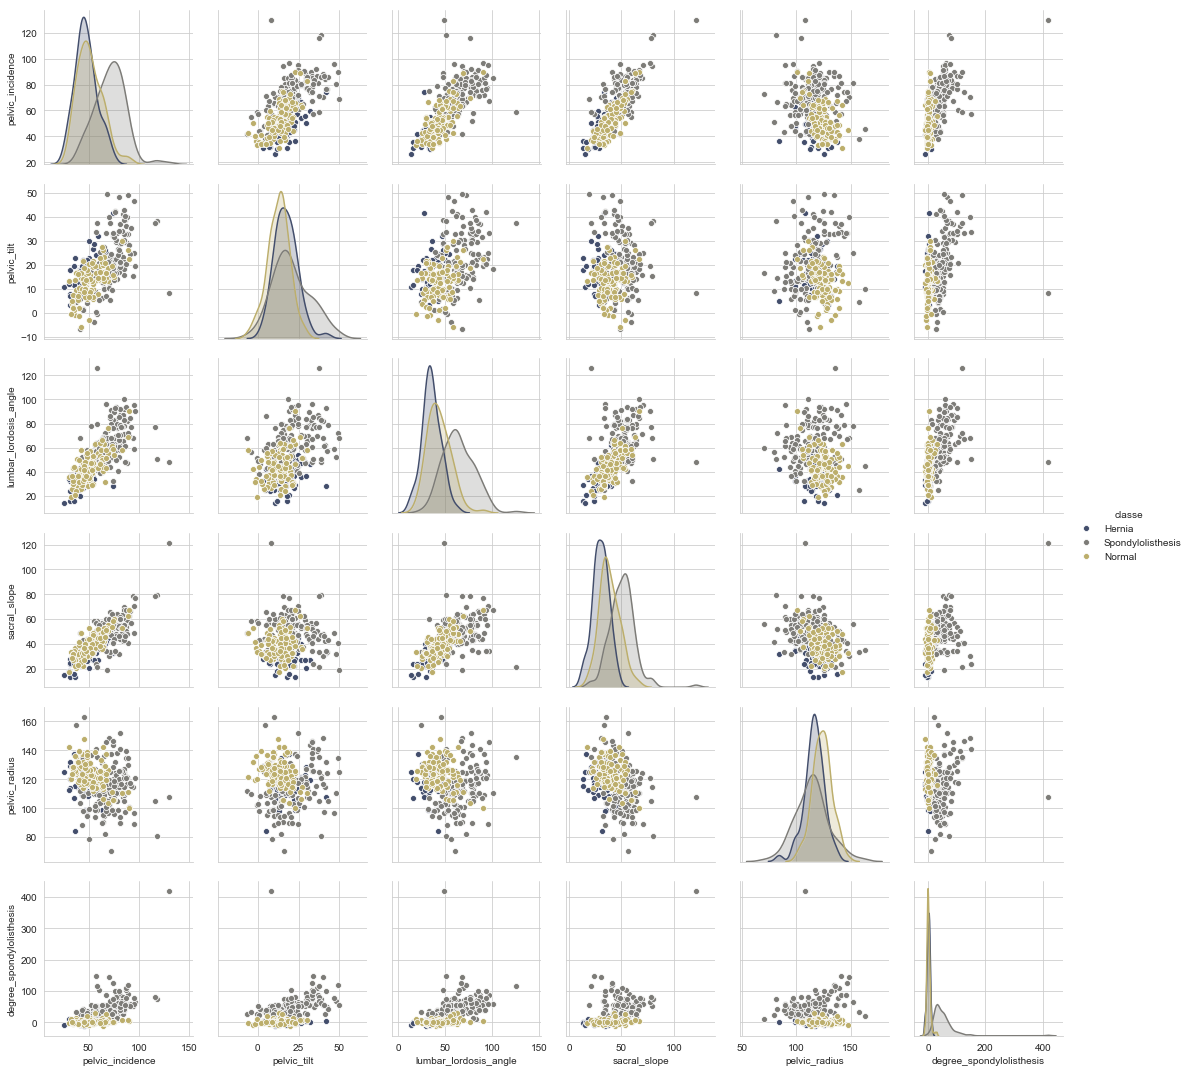

In [10]:
sns.pairplot (df, hue="classe", palette="cividis")

#### Verificando com mais detalhes a distribuição de inclinação sacral e raio pélvico

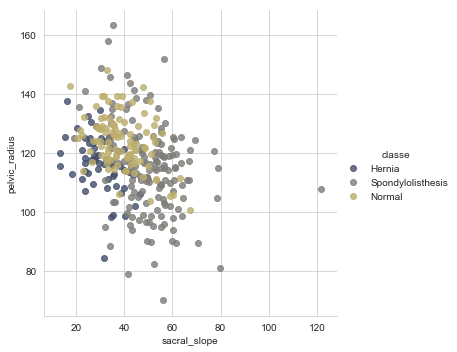

In [11]:
sns.lmplot (x="sacral_slope", y="pelvic_radius", hue="classe", data=df, fit_reg=False, palette="cividis")

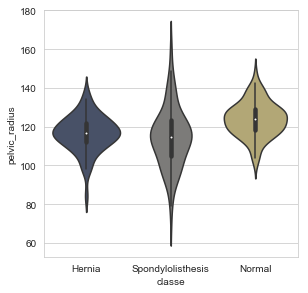

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.violinplot(x="classe",y="pelvic_radius",data=df, palette="cividis")

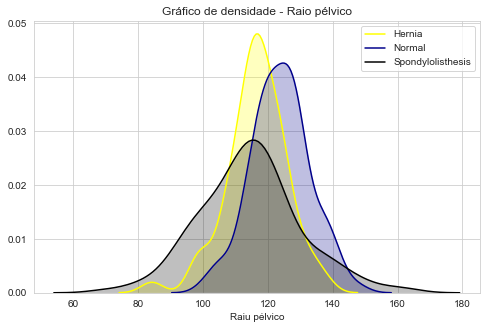

In [13]:
plt.figure(figsize=(8,5))
sns.kdeplot(df["pelvic_radius"][df.classe == "Hernia"], color="yellow", shade=True)
sns.kdeplot(df["pelvic_radius"][df.classe == "Normal"], color="darkblue", shade=True)
sns.kdeplot(df["pelvic_radius"][df.classe == "Spondylolisthesis"], color="black", shade=True)
plt.legend(['Hernia', 'Normal', "Spondylolisthesis"])
plt.title('Gráfico de densidade - Raio pélvico')
plt.xlabel ("Raiu pélvico")
plt.show()

Spondylolisthesis    150
Normal               100
Hernia                60
Name: classe, dtype: int64

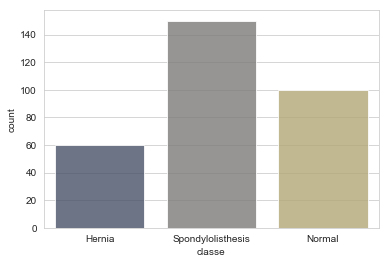

In [14]:
sns.countplot ("classe", data=df, alpha=0.8, palette="cividis")
df["classe"].value_counts()

#### Curva de Andrews - Método para visualizar dados multidimensionais, mapeando cada observação em uma função.

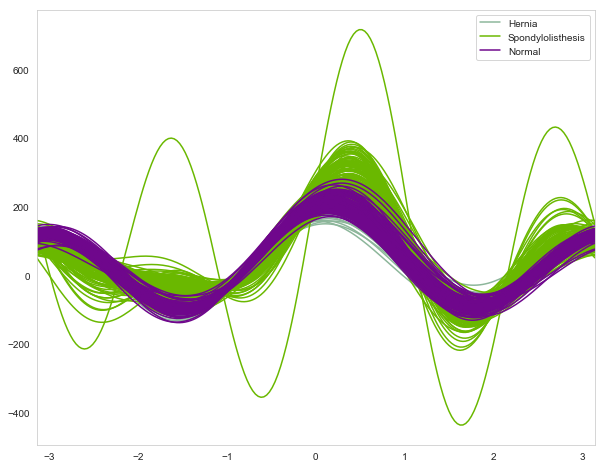

In [15]:
from pandas.plotting import andrews_curves
plt.figure(figsize=(10,8))
andrews_curves(df,'classe')

## 3 - Data wrangling 

#### Substituindo os 3 termos de classificação por valores numéricos (0,1 e 2)

In [16]:
def map_data(database):

    classe_map = { "Normal":0, "Hernia":1, "Spondylolisthesis": 2}
    database['classe'] = database['classe'].map(classe_map)    
    return database

df = map_data(df)
df.head(3)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,classe
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1


In [17]:
df["classe"].value_counts()

2    150
0    100
1     60
Name: classe, dtype: int64

## 5 - Machine learning (KNN - K Nearest Neighbors)

#### Padronização dos dados

In [41]:
scaler = StandardScaler()

In [42]:
scaler.fit (df.drop("classe", axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [43]:
transform = scaler.transform (df.drop("classe", axis=1))

#### Verificando a padronização (normalização)

In [44]:
df_transform = pd.DataFrame(transform,columns=df.columns[:-1])
df_transform.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
0,0.147086,0.501369,-0.665177,-0.184950,-1.447647,-0.708059
1,-1.245864,-0.748769,-1.453001,-1.041521,-0.264385,-0.579556
2,0.484370,0.467932,-0.099262,0.273083,-0.897686,-0.795421
3,0.511390,0.711562,-0.411339,0.126128,-1.207303,-0.402288
4,-0.626648,-0.789693,-1.274745,-0.215876,-0.733455,-0.490106


#### Dividindo os dados entre treino e test

In [161]:
X_train, X_test, y_train, y_test = train_test_split (transform, df["classe"], test_size=0.25)

In [162]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(232, 6)
(232,)
(78, 6)
(78,)


#### Aplicando o modelo e fazendo a predição

In [163]:
knn = KNeighborsClassifier (n_neighbors=1)

In [164]:
knn.fit (X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [165]:
prediction = knn.predict (X_test)

In [166]:
print (confusion_matrix (y_test, prediction))

[[24  3  1]
 [ 5  3  0]
 [ 0  1 41]]


In [167]:
print (classification_report (y_test, prediction))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        28
           1       0.43      0.38      0.40         8
           2       0.98      0.98      0.98        42

   micro avg       0.87      0.87      0.87        78
   macro avg       0.74      0.74      0.74        78
weighted avg       0.87      0.87      0.87        78



#### O modelo teve 87% de acurácia com 1 vizinho (neighbord). 
#### O número de vizinhos mais próximos mais adequado por ser encontrado de algumas formas. Abaixo usarei a taxa de erro.

Text(0, 0.5, 'Error Rate')

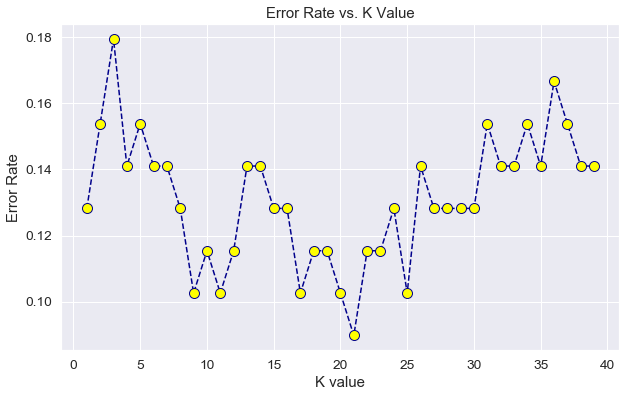

In [168]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier (n_neighbors=i)
    knn.fit (X_train,y_train)
    prediction_i = knn.predict (X_test)
    error_rate.append(np.mean(prediction_i != y_test))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='darkblue', linestyle='dashed', marker='o', markerfacecolor='yellow', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K value')
plt.ylabel('Error Rate')

#### Agora usando o accuray scores. Um gráfico obviamente é o inverso do outro.

Text(0, 0.5, 'Accuracy Score')

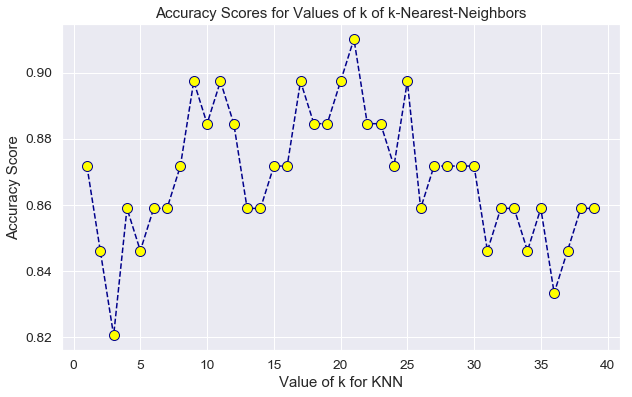

In [169]:
scores = []

for k in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    prediction_k = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, prediction_k))
    

plt.figure(figsize=(10,6))
plt.plot(range(1,40),scores ,color='darkblue', linestyle='dashed', marker='o', markerfacecolor='yellow', markersize=10)
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')

#### A melhor opção são 21 vizinhos. 

In [170]:
knn = KNeighborsClassifier(n_neighbors=21)

In [171]:
knn.fit (X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=21, p=2,
           weights='uniform')

In [172]:
prediction = knn.predict (X_test)

In [173]:
print (confusion_matrix (y_test, prediction))

[[26  1  1]
 [ 2  6  0]
 [ 3  0 39]]


In [174]:
print (classification_report (y_test, prediction))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        28
           1       0.86      0.75      0.80         8
           2       0.97      0.93      0.95        42

   micro avg       0.91      0.91      0.91        78
   macro avg       0.89      0.87      0.88        78
weighted avg       0.91      0.91      0.91        78



#### A acurácia do modelo melhorou de 87% para 91%

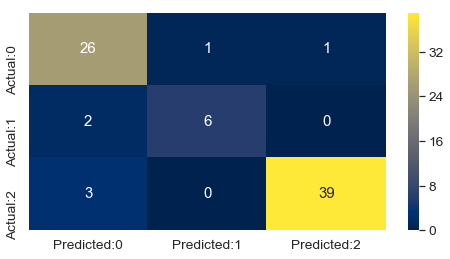

In [175]:
cm=confusion_matrix(y_test,prediction)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1', "Predicted:2"],index=['Actual:0','Actual:1',"Actual:2"])
plt.figure(figsize = (8,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="cividis")

## 6 - Resultados

In [176]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Precision or positive predictive value
PPV = TP/(TP+FP)

In [181]:
results = [
    ['Classificação', "Predição %", "Recall %"],
    [ "Normal",84,93],
    [ "Hernia",86,75],
    [ "Espondilolistese",97,93],
    ]
tbl.make_table(results) 

Classificação,Predição %,Recall %
Normal,84,93
Hernia,86,75
Espondilolistese,97,93


In [183]:
resultss = [
    ['The acuracy of the model = ',(accuracy_score(y_test, prediction))],
    ]
tbl.make_table(resultss)

The acuracy of the model =,0.9103


### Visualizando a correlação entre as variáveis

Coeficiente de correlação:

+1  = forte correlação positiva

0   = não há correlação

-1  = forte correlação negativa

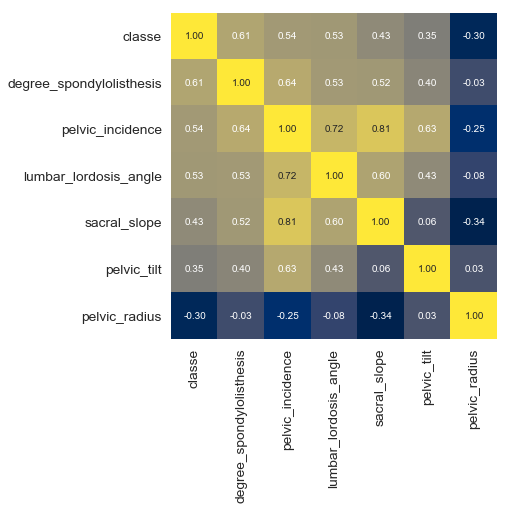

In [184]:
k = 7 #número de variáveis para o heatmap
corrmat = df.corr() #correlação
cols = corrmat.nlargest(k, 'classe')['classe'].index
cm = np.corrcoef(df[cols].values.T) #confusion matrix

plt.figure(figsize=(6,6))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values, cmap="cividis")
plt.show()

## 7 - Conclusão

- A incidência pélvica e a inclinação sacral tem a melhor correlação tendo a classe como parâmetro.


- O modelo obteve uma acurácia de 87% utilizando apenas 1 vizinho. Depois de calcular a taxa de erro e verificar o melhor número de vizinhos, o número de 21 vizinhos foi aplicado e obteve uma acurácia de 91%.


- A sensitividade é muito importante nesse tipo de análise, pois é o verdadeiro positivo. Sua acurácia foi de 93% (Normal), 75% (Hernia) e 93% (Espondilolistese).


- O bias do KNN associa valores semelhantes a instâncias semelhantes. Porém, ele considera semelhantes instâncias que tenham o mesmo valor para seus atributos.


- A acurácia poderia ter sido muito melhor e com maior segurança se obtivessem mais dados, pois esse dataset tinha pouco mais de 300 linhas. 
